## Bitcoin Price

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from mod_btc import crosscorr, plot_correlation
from sklearn import preprocessing

In [2]:
directory = '~/PycharmProjects/tfm_hugopobil'
btc = pd.read_csv(f'{directory}/data/BTC-USD.csv', low_memory=False)
btc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [4]:
tweets = pd.read_csv(f'{directory}/data/tweets_scores.csv', low_memory=False)

In [5]:
btc.Date = pd.to_datetime(btc.Date)

<AxesSubplot:>

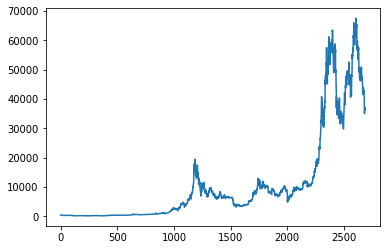

In [6]:
btc['Adj Close'].plot()

In [7]:
tweets = tweets.drop_duplicates()
tweets['date'] = pd.to_datetime(tweets['date'])
tweets.index = tweets['date']

In [13]:
tweets_grouped = tweets.resample('1D').sum()

In [14]:
btc_usd = btc.copy()
btc_usd['Date'] = pd.to_datetime(btc_usd['Date'], unit='s')
btc_usd.index = btc_usd['Date']

In [15]:
btc_usd_grouped = btc_usd.resample('D')['Adj Close'].mean()

## Plot tweets scores and BTC price

In [16]:
beg = max(tweets_grouped.index.min().replace(tzinfo=None),
          btc_usd_grouped.index.min())

end = min(tweets_grouped.index.max().replace(tzinfo=None),
          btc_usd_grouped.index.max())

tweets_grouped = tweets_grouped[beg:end]
btc_usd_grouped = btc_usd_grouped[beg:end]

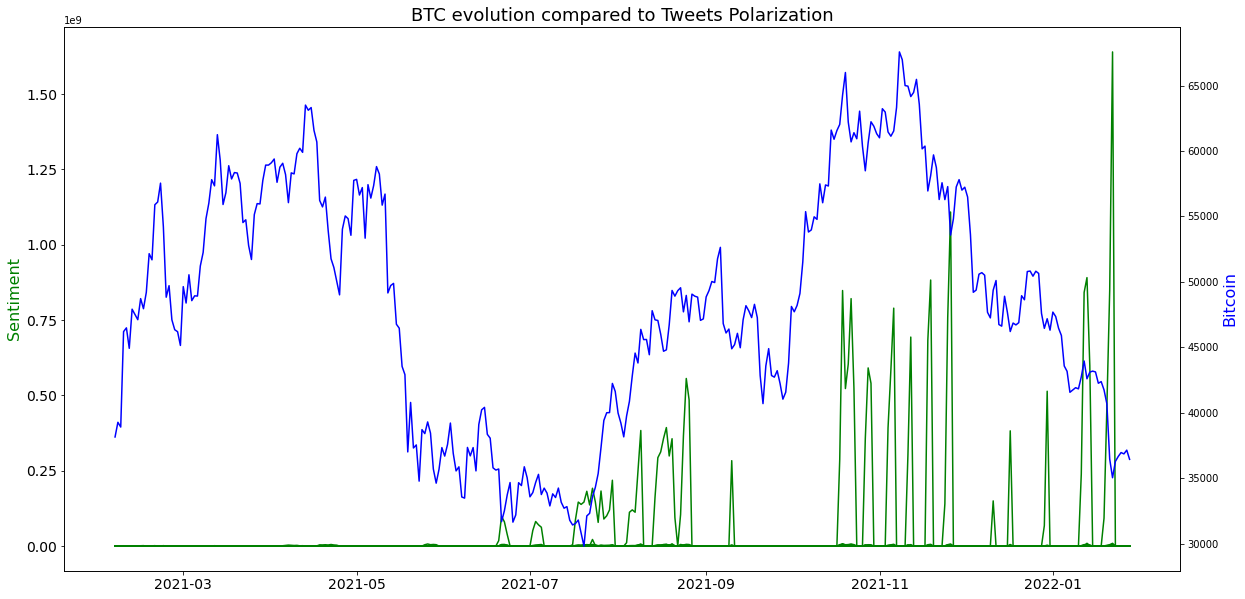

In [17]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title('BTC evolution compared to Tweets Polarization', fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot(tweets_grouped, 'g-')
ax2.plot(btc_usd_grouped, 'b-')
# ax2.axis_date(btc_usd_grouped.index, btc_usd_grouped, 'b-')

# Add color to labels
ax1.set_ylabel('Sentiment', color='g', fontsize=16)
ax2.set_ylabel('Bitcoin', color='b', fontsize=16)
plt.show()

# Meter leyenda!

### Save data to local

In [26]:
tweets_grouped.to_csv(f'{directory}/data/tweets_grouped.csv')
btc_usd_grouped.to_csv(f'{directory}/data/btc_usd_grouped.csv')

## Correlations

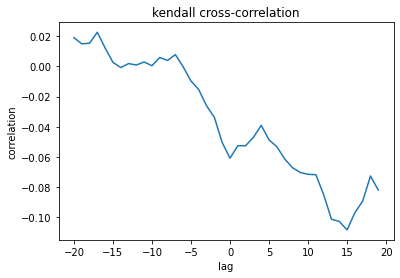

In [18]:
plot_correlation(tweets = tweets_grouped,
                 bitcoin = btc_usd_grouped,
                 method = 'kendall')

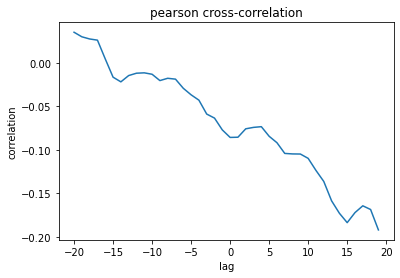

In [19]:
plot_correlation(tweets = tweets_grouped,
                 bitcoin = btc_usd_grouped,
                 method = 'pearson')

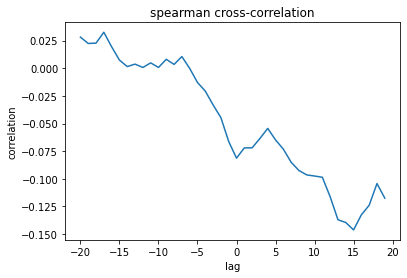

In [20]:
plot_correlation(tweets = tweets_grouped,
                 bitcoin = btc_usd_grouped,
                 method = 'spearman')

## Normalization

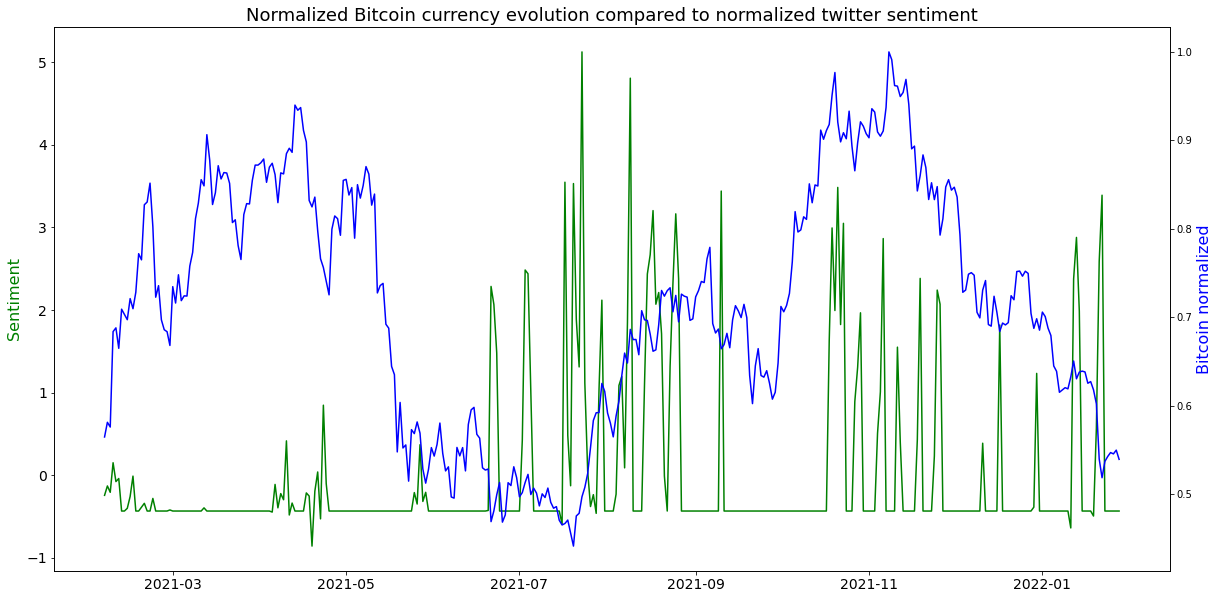

In [21]:
min_max_scaler = preprocessing.StandardScaler()
score_scaled = min_max_scaler.fit_transform(tweets_grouped['score'].values.reshape(-1, 1))

tweets_grouped['normalized_score'] = score_scaled
crypto_used_grouped_scaled = btc_usd_grouped / max(btc_usd_grouped.max(), abs(btc_usd_grouped.min()))

fig, ax1 = plt.subplots(figsize=(20, 10))
ax1.set_title("Normalized Bitcoin currency evolution compared to normalized twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped['normalized_score'], 'g-')
ax2.plot_date(btc_usd_grouped.index, crypto_used_grouped_scaled, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel("Bitcoin normalized", color='b', fontsize=16)
plt.show()

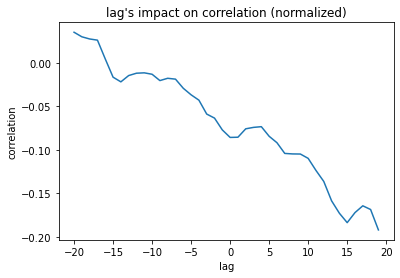

In [22]:
xcov = [crosscorr(detax=tweets_grouped,
                  detay=btc_usd_grouped,
                  method='pearson',
                  lag=i) for i in range(-20,20)]

plt.plot(range(-20,20), xcov)
plt.title("lag's impact on correlation (normalized)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

## Derivative of Bitcoin's Price

In [23]:
# Derivative
tweets_grouped_derivative = pd.Series(np.gradient(
    tweets_grouped['normalized_score'].values),
    tweets_grouped.index,
    name='slope')

btc_usd_grouped_derivative = pd.Series(np.gradient(
    btc_usd_grouped.values),
    btc_usd_grouped.index,
    name='slope')

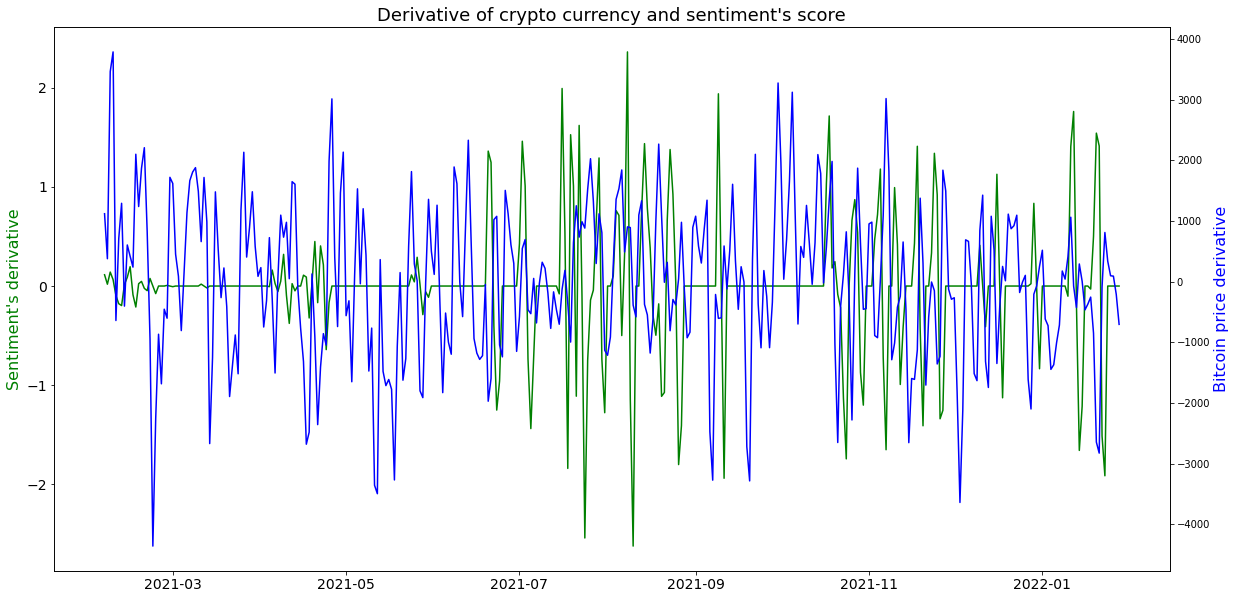

In [24]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Derivative of crypto currency and sentiment's score", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped_derivative.index, tweets_grouped_derivative, 'g-')
ax2.plot_date(btc_usd_grouped_derivative.index, btc_usd_grouped_derivative, 'b-')

ax1.set_ylabel("Sentiment's derivative", color='g', fontsize=16)
ax2.set_ylabel('Bitcoin price derivative', color='b', fontsize=16)
plt.show()

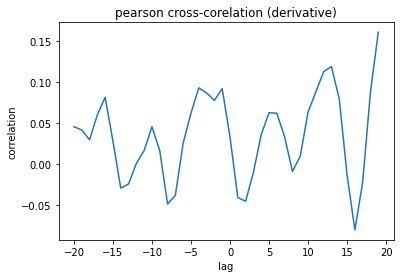

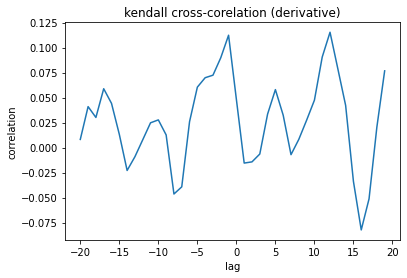

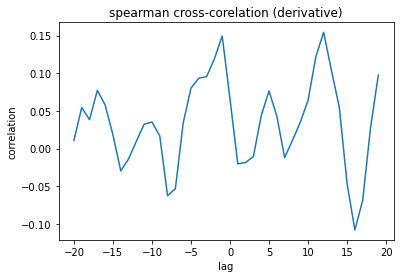

In [25]:
xcov = [crosscorr(tweets_grouped, btc_usd_grouped_derivative, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, btc_usd_grouped_derivative, lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("kendall cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, btc_usd_grouped_derivative, lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("spearman cross-corelation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()